In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import model
from datetime import datetime
from datetime import timedelta
import copy
sns.set()

In [2]:
df = pd.read_csv('/home/husein/space/Stock-Prediction-Comparison/dataset/GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055572,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


In [4]:
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 50

In [5]:
def contruct_cells(hidden_structs):
    cells = []
    for hidden_dims in hidden_structs: cells.append(tf.contrib.rnn.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(hidden_dims, state_is_tuple = False),
                                                                                  output_keep_prob = 0.7))
    return cells

def rnn_reformat(x, input_dims, n_steps):
    x_ = tf.transpose(x, [1, 0, 2])
    x_ = tf.reshape(x_, [-1, input_dims])
    return tf.split(x_, n_steps, 0)

def dilated_rnn(cell, inputs, rate, states, scope='default'):
    n_steps = len(inputs)
    if not (n_steps % rate) == 0:
        zero_tensor = tf.zeros_like(inputs[0])
        dilated_n_steps = n_steps // rate + 1
        for i_pad in range(dilated_n_steps * rate - n_steps): inputs.append(zero_tensor)
    else:
        dilated_n_steps = n_steps // rate
    dilated_inputs = [tf.concat(inputs[i * rate:(i + 1) * rate], axis=0) for i in range(dilated_n_steps)]
    dilated_outputs, states = tf.contrib.rnn.static_rnn(cell, dilated_inputs, 
                                                        initial_state=states,
                                                        dtype=tf.float32, scope=scope)
    splitted_outputs = [tf.split(output, rate, axis=0) for output in dilated_outputs]
    unrolled_outputs = [output for sublist in splitted_outputs for output in sublist]
    return unrolled_outputs[:n_steps], states

def multi_dilated_rnn(cells, inputs, dilations, states):
    x = copy.copy(inputs)
    count = 0
    for cell, dilation in zip(cells, dilations):
        x, states = dilated_rnn(cell, x, dilation, states, scope="multi_dilated_rnn_%d" % count)
        count += 1
    return x, states

class Model:
    def __init__(self, steps, dimension_input, dimension_output, learning_rate = 0.001, 
                 hidden_structs = [20], dilations = [1, 1, 1, 1]):
        hidden_structs = hidden_structs * len(dilations)
        self.X = tf.placeholder(tf.float32, [None, steps, dimension_input])
        self.Y = tf.placeholder(tf.float32, [None, dimension_output])
        self.hidden_layer = tf.placeholder(tf.float32, (None, 40))
        x_reformat = rnn_reformat(self.X, dimension_input, steps)
        cells = contruct_cells(hidden_structs)
        layer_outputs, self.last_state = multi_dilated_rnn(cells, x_reformat, dilations, self.hidden_layer)
        if dilations[0] == 1:
            weights = tf.Variable(tf.random_normal(shape=[hidden_structs[-1], dimension_output]))
            bias = tf.Variable(tf.random_normal(shape=[dimension_output]))
            self.logits = tf.matmul(layer_outputs[-1], weights) + bias
        else:
            weights = tf.Variable(tf.random_normal(shape=[hidden_structs[-1] * dilations[0], dimension_output]))
            bias = tf.Variable(tf.random_normal(shape=[dimension_output]))
            for idx, i in enumerate(range(-dilations[0], 0, 1)):
                if idx == 0:
                    hidden_outputs_ = layer_outputs[i]
                else:
                    hidden_outputs_ = tf.concat([hidden_outputs_, layer_outputs[i]],axis=1)
            self.logits = tf.matmul(hidden_outputs_, weights) + bias
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [6]:
tf.reset_default_graph()
modelnn = model = Model(timestamp, df_log.shape[1], df_log.shape[1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, 40))
    total_loss = 0
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_log.iloc[k: k + timestamp, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1: k + timestamp + 1, :].values
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (df_log.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.015005237497389317
epoch: 200 avg loss: 0.0074345169542357325
epoch: 300 avg loss: 0.007217556593823247
epoch: 400 avg loss: 0.005578229161328636
epoch: 500 avg loss: 0.005964752285508439


In [7]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, 40))

for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    try:
        out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[k: k + timestamp, :], axis = 0),
                                         modelnn.hidden_layer: init_value})
        output_predict[k + 1: k + timestamp + 1, :] = out_logits
    except:
        out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
                                         modelnn.hidden_layer: init_value})
        output_predict[df_log.shape[0]-timestamp:df_log.shape[0],:] = out_logits
    init_value = last_state

df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1]+timedelta(days=1))

In [8]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1]+timedelta(days=1))

In [9]:
df_log = minmax.inverse_transform(output_predict)
date_ori=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

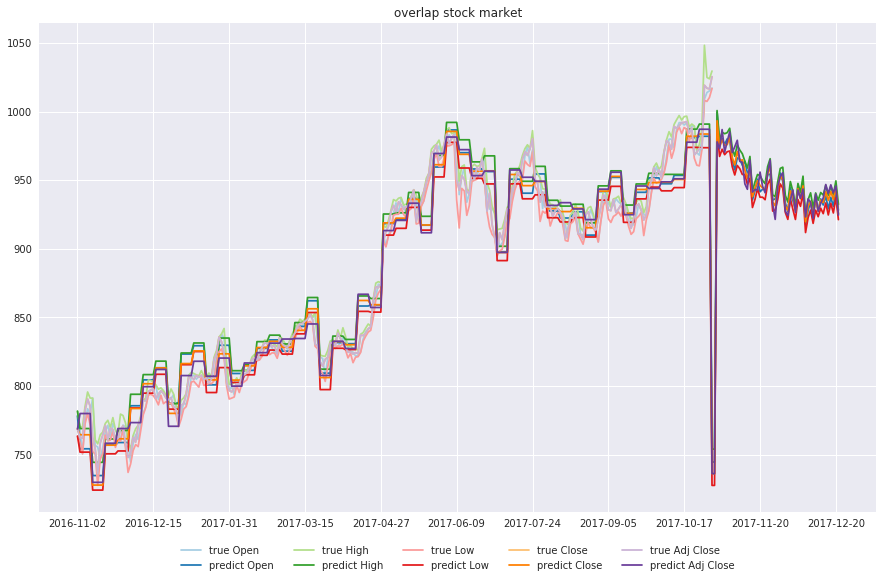

In [10]:
current_palette = sns.color_palette("Paired", 12)
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(x_range_original, df.iloc[:, 1], label = 'true Open', color = current_palette[0])
ax.plot(x_range_future, df_log[:, 0], label = 'predict Open', color = current_palette[1])
ax.plot(x_range_original, df.iloc[:, 2], label = 'true High', color = current_palette[2])
ax.plot(x_range_future, df_log[:, 1], label = 'predict High', color = current_palette[3])
ax.plot(x_range_original, df.iloc[:, 3], label = 'true Low', color = current_palette[4])
ax.plot(x_range_future, df_log[:, 2], label = 'predict Low', color = current_palette[5])
ax.plot(x_range_original, df.iloc[:, 4], label = 'true Close', color = current_palette[6])
ax.plot(x_range_future, df_log[:, 3], label = 'predict Close', color = current_palette[7])
ax.plot(x_range_original, df.iloc[:, 5], label = 'true Adj Close', color = current_palette[8])
ax.plot(x_range_future, df_log[:, 4], label = 'predict Adj Close', color = current_palette[9])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

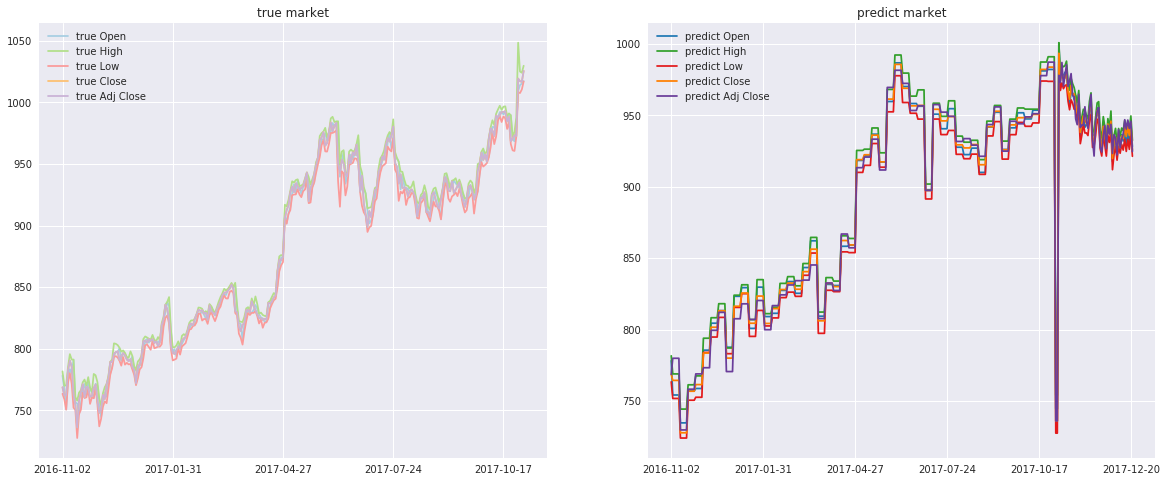

In [11]:
fig = plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, 1], label = 'true Open', color = current_palette[0])
plt.plot(x_range_original, df.iloc[:, 2], label = 'true High', color = current_palette[2])
plt.plot(x_range_original, df.iloc[:, 3], label = 'true Low', color = current_palette[4])
plt.plot(x_range_original, df.iloc[:, 4], label = 'true Close', color = current_palette[6])
plt.plot(x_range_original, df.iloc[:, 5], label = 'true Adj Close', color = current_palette[8])
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, df_log[:, 0], label = 'predict Open', color = current_palette[1])
plt.plot(x_range_future, df_log[:, 1], label = 'predict High', color = current_palette[3])
plt.plot(x_range_future, df_log[:, 2], label = 'predict Low', color = current_palette[5])
plt.plot(x_range_future, df_log[:, 3], label = 'predict Close', color = current_palette[7])
plt.plot(x_range_future, df_log[:, 4], label = 'predict Adj Close', color = current_palette[9])
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

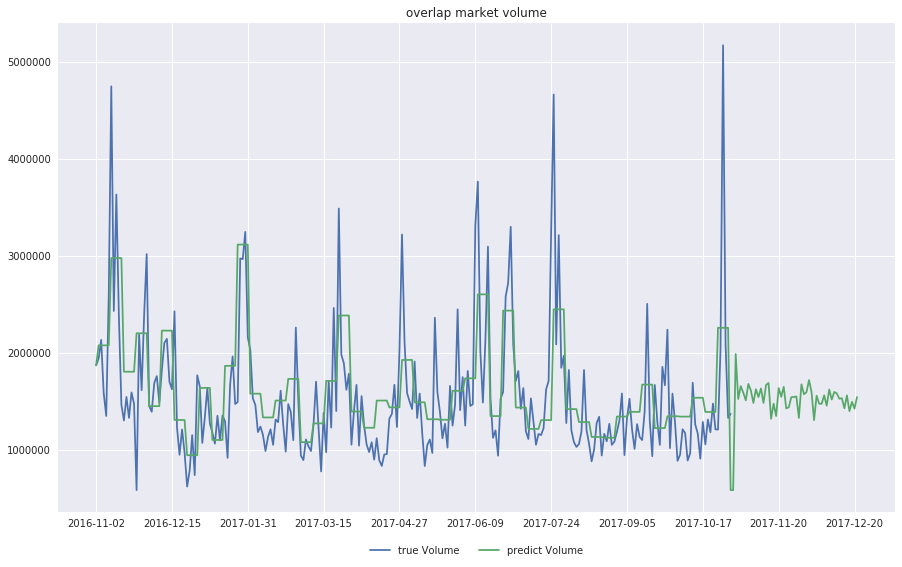

In [12]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, df_log[:, -1], label = 'predict Volume')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

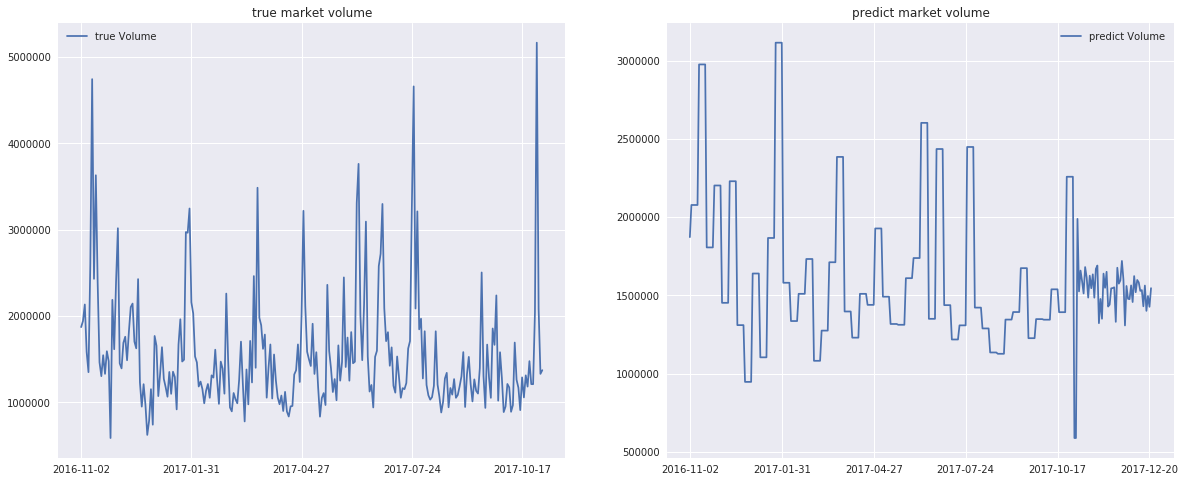

In [13]:
fig = plt.figure(figsize = (20,8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, df_log[:, -1], label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()